In [22]:
import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost
import warnings
warnings.filterwarnings('ignore')
import time

In [23]:
df = pd.read_pickle('data_cleaned')

In [24]:
target_col = ['Price'] 

features_cols = ['Make', 'Milage', 'Year', 'Power', 'Consumption', 'Cylinder',
       'Gears', 'Fuel Type', 'Transmission', 'Body type', 'CO2 emission',
       'Door', 'Seat', 'Engine size', 'data_source', 'Model_1']

In [25]:
def data_stratification(df_, grp_col, n_grp):
    
    '''to divide data in stratified chunks.
    Remaining data to put very last chunk.
    
    Parameters: df_:dataframe
                grp_col: field to get proportions
                n_grp: number of desired group
            
    Return: the index numbers of each group within a dictionary
    
    '''
    
    idx_dict = {}
    n = n_grp

    for i in range(n_grp):

        idx=[]  

        for grp in df_[grp_col].unique():

            data = df_[df_[grp_col]==grp]
            num_data = len(data)//(n_grp)
            pro_data = len(data)/(n_grp)
            
            if n_grp > 1:

                if num_data >= 1:
                    idx.append(list(data.sample(num_data, replace=True).index))

                elif (pro_data <= 1) & (pro_data > 0):
                    idx.append(list(data.sample(1, replace=True).index))

            elif n_grp == 1:
                idx.append(list(data.index))

        idx = list(set([col for row in idx for col in row]))    
        idx_dict[i+1] = idx   
        n_grp -= 1
        df_.drop(index=idx, inplace=True)
    
    idx_dict[0] = idx_dict[n]
    idx_dict.pop(n, None)
    idx_dict = dict(sorted(idx_dict.items()))
    
    return idx_dict

In [26]:
def eval_metrics(actual, pred):
    '''to evaluate performance of regression model
    
    Parameters: actual: actual values
                pred: predicted value
                
    Return: pandas series of evaluations metrics of ML model            
    '''
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    a = pd.DataFrame({'actual': actual, 'pred': pred})
    per_mae = np.mean(abs(a.actual - a.pred)/a.actual * 100)
    mse = mean_squared_error(actual, pred)
    r_score = r2_score(actual, pred)
    corr = a.actual.corr(a.pred)
    
    data = pd.Series([r_score, mae, per_mae, mse, rmse, corr], 
                     index=['R2 score', 'MAE', '% of MAE', 'MSE', 'RMSE', 'Correlation'])
    return data.round(3)

In [27]:
def act_pred_data(actual, pred):
    '''create a df with actual, predicted and % of errors
    
    Parameters: actual: str: actual values
                pred: str: predicted values
    Returns a df
    '''
    a = pd.DataFrame({'actual': actual, 'pred': pred})
    a['per_err'] = abs(a.actual - a.pred)/a.actual * 100
    
    return a

In [28]:
def scatter_corr(actual, pred, df):
    '''to draw a scatter plot of actual values vs predicted value with correlation of them
    Parameters: actual: str: actual values
                pred: str: predicted values
                df: dataframe
    
    Return: scatter plot of actual value vs predicted value
    '''
    correlation = df[actual].corr(df[pred])
    
    x = [i for i in range(int(np.min(df[actual])), int(np.max(df[actual])))]
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=actual, y=pred, data=df)
    plt.plot(x, x, color='black')
    plt.plot(np.unique(df[actual]), np.poly1d(np.polyfit(df[actual], df[pred], 1))
             (np.unique(df[actual])), color='red')
    plt.title(f'Correlation of Actual vs Predicted values: {correlation:.2f}', 
              fontdict={'size':18, 'color':'darkred'})
    plt.xlabel('Actual Values', fontdict={'size':15, 'color':'black'})
    plt.ylabel('Predicted Values',fontdict={'size':15, 'color':'black'})

In [29]:
def concat_data(grp):
    '''concatenates new data points into model data
    
    Parameters: grp: groups from idx_grp dictionary
    
    '''
    idx = idx_grp[grp]
    
    global df
    df_n = df.loc[idx]
    
    global data
    data = pd.concat([data, df_n])
    
    #return data

In [30]:
def slide(grp):
    
    idx = idx_grp[grp]
    sliding_window = len(idx)
      
    global data

    idx_del = list(data[0:sliding_window].index)
    
    data = data.drop(index=idx_del)

    df_n = df.loc[idx]

    data = pd.concat([data, df_n])

    

In [31]:
def split_data():
    '''splits data into train test split
    '''
    
    global data
    X = pd.get_dummies(data[features_cols])
    y = data['Price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    return X_train, X_test, y_train, y_test
    
    

In [32]:
def modelling():
    
    global X_train, X_test, y_train, y_test
    
    xgb_model = xgboost.XGBRegressor().fit(X_train, y_train)
        
    return xgb_model

In [33]:
def pred_values(model):
    
    global X_test
    
    y_pred = model.predict(X_test)
    
    return y_pred
    

# Experiments

**Data Chunks**

In [34]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

In [35]:
idx_grp = data_stratification(df_, 'Group', 18)

## Experiment 1

17 data chunks will be concatenated each at a time to see how model performance chages when the size of data increasing overtime.

In [36]:
data = pd.DataFrame()

for grp in idx_grp.keys():
    
    concat_data(grp)
    X_train, X_test, y_train, y_test = split_data()
    start = time.time()
    model = modelling()
    end = time.time()
    y_pred = pred_values(model)
    globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
    globals()[f'time_{grp}'] = end - start
    globals()[f'size_{grp}'] = len(data)
        

In [37]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp1 = pd.concat([exp_res, a])

df_scores_exp1.rename(columns=cols, inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

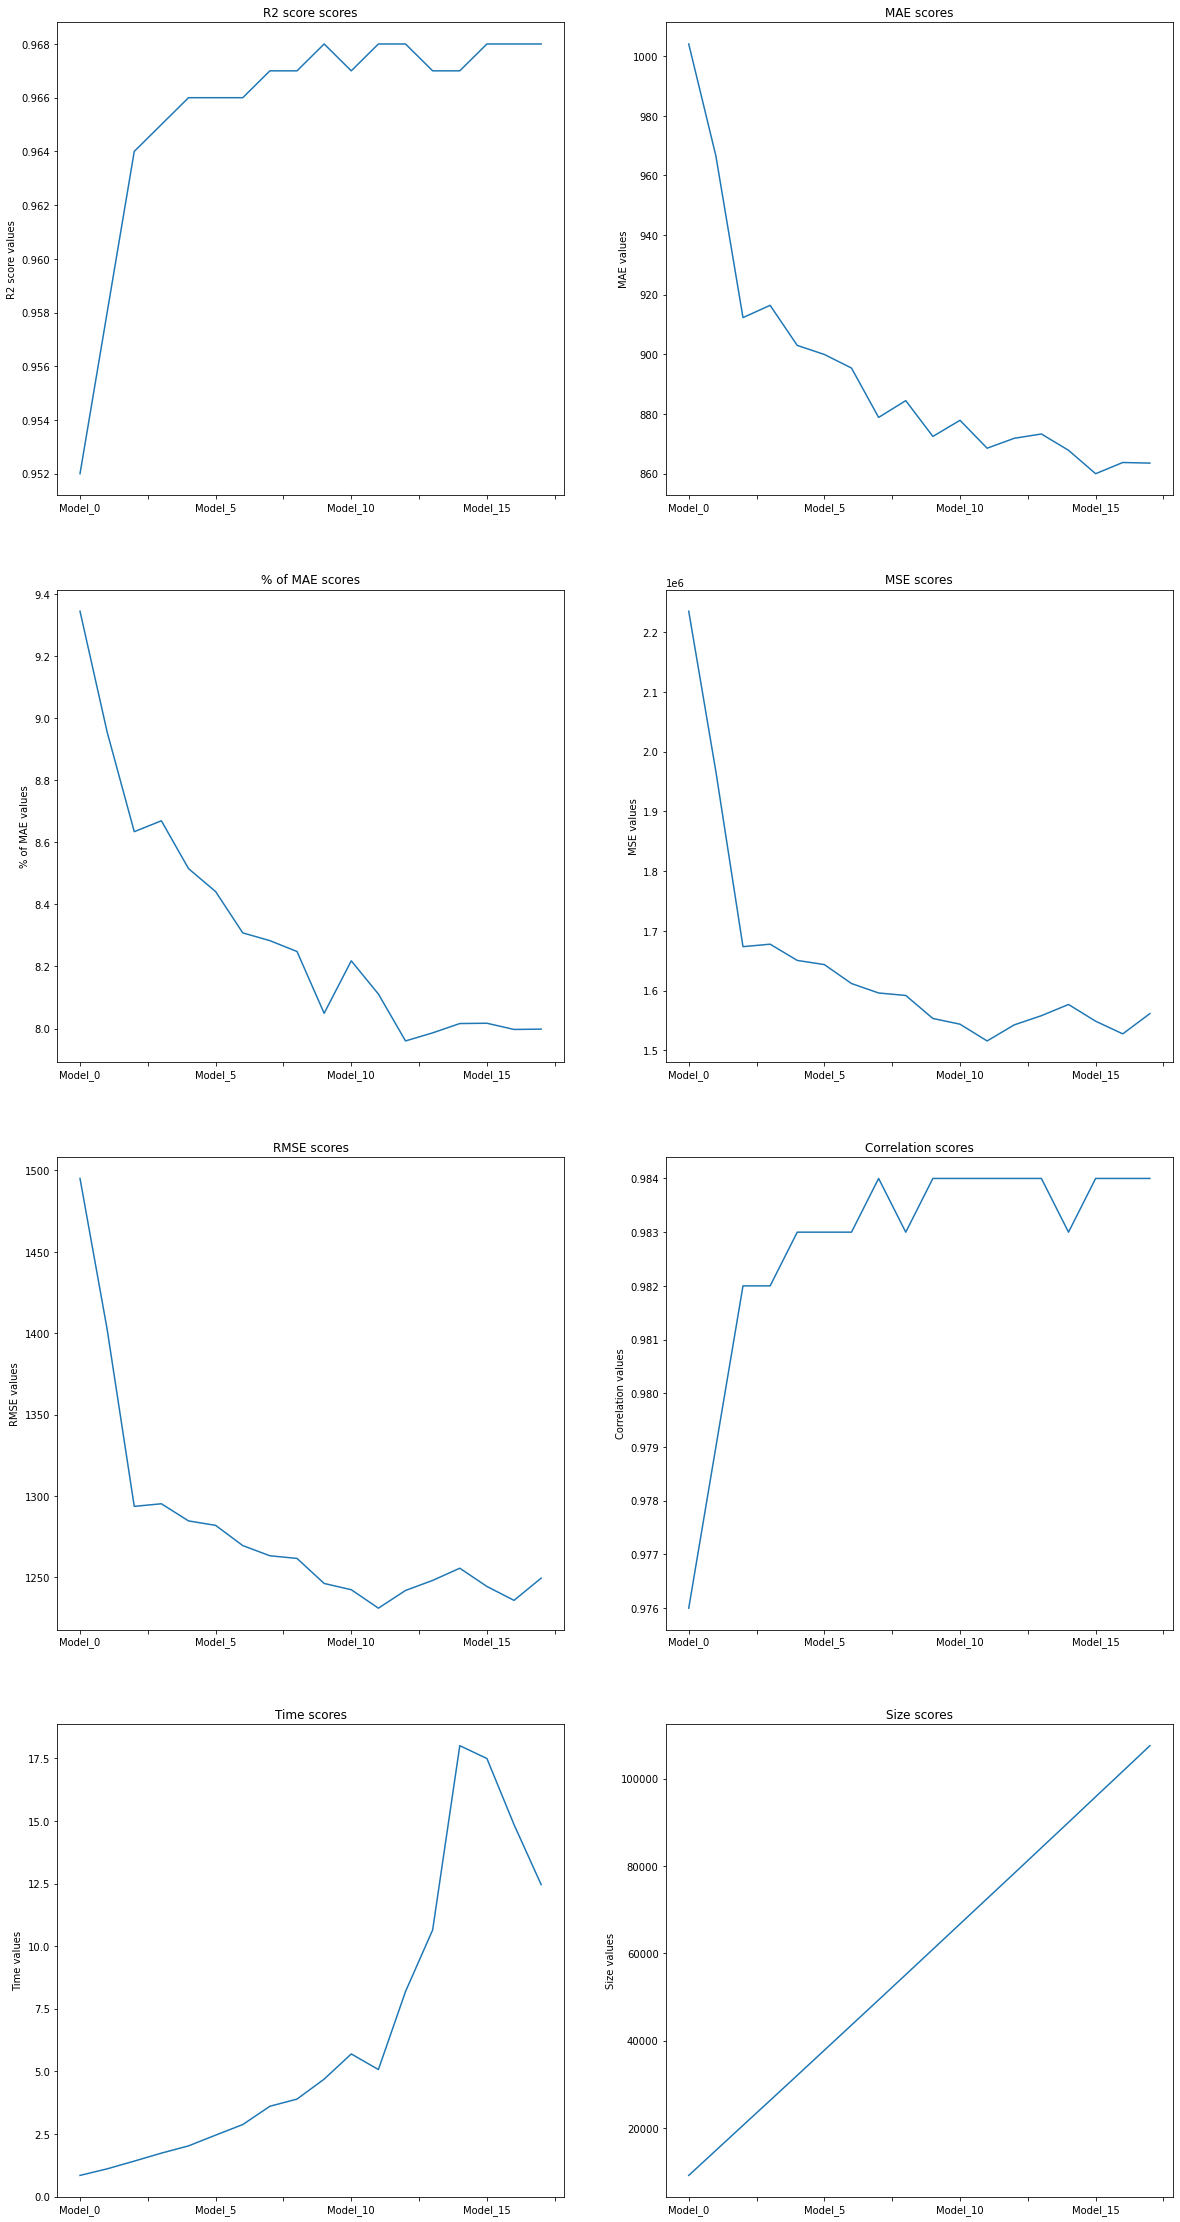

In [38]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp1.index):
    plt.subplot(4,2,i+1)
    df_scores_exp1.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [39]:
df_scores_exp1.to_excel('exp1_scores.xlsx')

## Experiment 2

In this experiment I will keep amount of data constant after a certain point to observe scores.

In [40]:
data = pd.DataFrame()

for grp in idx_grp.keys():
          
    if len(data) < 70000:
        concat_data(grp)
    else:
        slide(grp)

    X_train, X_test, y_train, y_test = split_data()
    start = time.time()
    model = modelling()
    end = time.time()
    y_pred = pred_values(model)
    globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
    globals()[f'time_{grp}'] = end - start
    globals()[f'size_{grp}'] = len(data)

In [41]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp2 = pd.concat([exp_res, a])

df_scores_exp2.rename(columns=cols, inplace=True)

In [42]:
df_scores_exp2

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Model_11,Model_12,Model_13,Model_14,Model_15,Model_16,Model_17
R2 score,9.520000e-01,9.580000e-01,9.640000e-01,9.650000e-01,9.660000e-01,9.660000e-01,9.660000e-01,9.670000e-01,9.670000e-01,9.680000e-01,9.670000e-01,9.680000e-01,9.670000e-01,9.670000e-01,9.670000e-01,9.680000e-01,9.680000e-01,9.680000e-01
MAE,1.004089e+03,9.666030e+02,9.123410e+02,9.164580e+02,9.030250e+02,8.999780e+02,8.954270e+02,8.788730e+02,8.845040e+02,8.725020e+02,8.779070e+02,8.685520e+02,8.794120e+02,8.779550e+02,8.706920e+02,8.644110e+02,8.677260e+02,8.712000e+02
% of MAE,9.344000e+00,8.955000e+00,8.634000e+00,8.669000e+00,8.515000e+00,8.441000e+00,8.308000e+00,8.283000e+00,8.248000e+00,8.049000e+00,8.218000e+00,8.111000e+00,8.161000e+00,8.048000e+00,7.932000e+00,7.921000e+00,8.075000e+00,7.939000e+00
MSE,2.235227e+06,1.966909e+06,1.673536e+06,1.677687e+06,1.650525e+06,1.643489e+06,1.611787e+06,1.595975e+06,1.591846e+06,1.553294e+06,1.543709e+06,1.515676e+06,1.614237e+06,1.613701e+06,1.586547e+06,1.531851e+06,1.526380e+06,1.545308e+06
RMSE,1.495068e+03,1.402465e+03,1.293652e+03,1.295256e+03,1.284728e+03,1.281986e+03,1.269562e+03,1.263319e+03,1.261684e+03,1.246312e+03,1.242461e+03,1.231128e+03,1.270526e+03,1.270315e+03,1.259582e+03,1.237680e+03,1.235468e+03,1.243104e+03
Correlation,9.760000e-01,9.790000e-01,9.820000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.840000e-01,9.830000e-01,9.840000e-01,9.840000e-01,9.840000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.840000e-01,9.840000e-01,9.840000e-01
Time,2.055053e+00,2.159463e+00,2.527898e+00,2.411706e+00,3.022198e+00,3.317411e+00,3.784104e+00,4.515724e+00,4.749909e+00,4.996985e+00,5.357129e+00,5.966800e+00,6.064922e+00,6.367446e+00,5.315234e+00,5.400630e+00,6.819639e+00,7.084158e+00
Size,9.129000e+03,1.485400e+04,2.058900e+04,2.630800e+04,3.205100e+04,3.781400e+04,4.357500e+04,4.934200e+04,5.513300e+04,6.093000e+04,6.674200e+04,7.254900e+04,7.254900e+04,7.254900e+04,7.254900e+04,7.254900e+04,7.254900e+04,7.254900e+04


<function matplotlib.pyplot.show(close=None, block=None)>

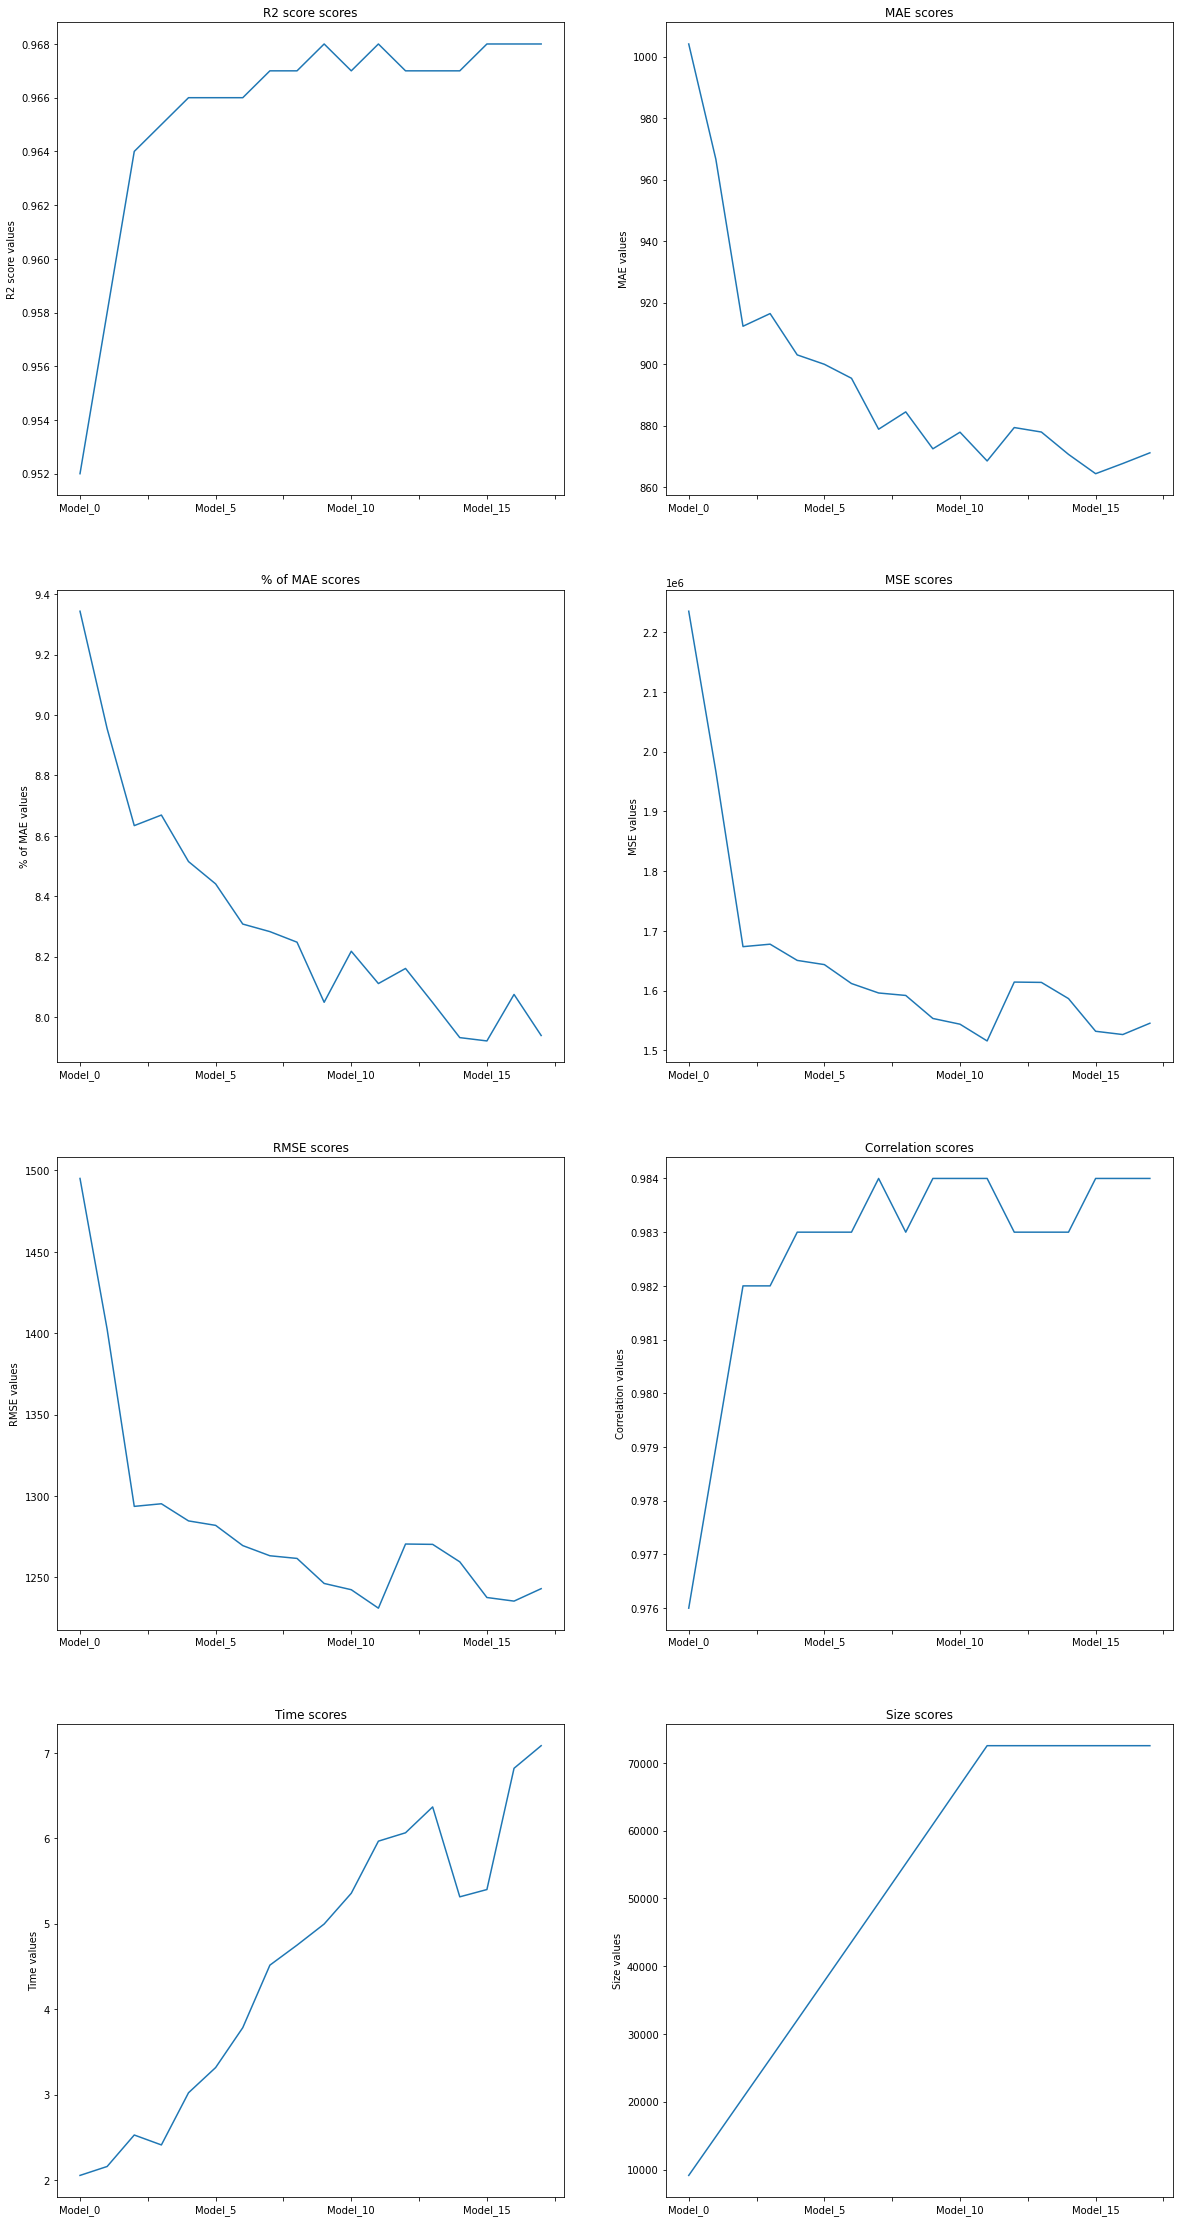

In [43]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp2.index):
    plt.subplot(4,2,i+1)
    df_scores_exp2.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [44]:
df_scores_exp2.to_excel('exp2_scores.xlsx')

## Experiment 3

Deciding breaking point

In [45]:
data = pd.DataFrame()

process_dict = {}

for grp in idx_grp.keys():
   
    if grp > 1:

        
        if globals()[f'per_mae_{grp-1}'] - globals()[f'per_mae_{grp-2}'] > 0.01:
            
            concat_data(grp)
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp)
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else:
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
        

In [46]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp3 = pd.concat([exp_res, a])

df_scores_exp3.rename(columns=cols, inplace=True)

In [47]:
df_scores_exp3

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Model_11,Model_12,Model_13,Model_14,Model_15,Model_16,Model_17
R2 score,9.520000e-01,9.580000e-01,9.610000e-01,9.610000e-01,9.600000e-01,9.650000e-01,9.630000e-01,9.640000e-01,9.630000e-01,9.640000e-01,9.650000e-01,9.650000e-01,9.650000e-01,9.640000e-01,9.660000e-01,9.660000e-01,9.660000e-01,9.660000e-01
MAE,1.004089e+03,9.666030e+02,9.830960e+02,9.549200e+02,9.557310e+02,9.358910e+02,9.405810e+02,9.190050e+02,9.347300e+02,9.157570e+02,8.980020e+02,9.040120e+02,9.035990e+02,9.145830e+02,8.973340e+02,9.034280e+02,8.987920e+02,8.952040e+02
% of MAE,9.344000e+00,8.955000e+00,9.084000e+00,9.046000e+00,8.769000e+00,8.781000e+00,8.789000e+00,8.533000e+00,8.577000e+00,8.353000e+00,8.391000e+00,8.337000e+00,8.273000e+00,8.507000e+00,8.121000e+00,8.231000e+00,8.133000e+00,8.164000e+00
MSE,2.235227e+06,1.966909e+06,1.968226e+06,1.939097e+06,1.991793e+06,1.787626e+06,1.784982e+06,1.754417e+06,1.781972e+06,1.781244e+06,1.659617e+06,1.671323e+06,1.675114e+06,1.749683e+06,1.631562e+06,1.668167e+06,1.664768e+06,1.639432e+06
RMSE,1.495068e+03,1.402465e+03,1.402935e+03,1.392514e+03,1.411309e+03,1.337021e+03,1.336032e+03,1.324544e+03,1.334905e+03,1.334632e+03,1.288261e+03,1.292797e+03,1.294262e+03,1.322756e+03,1.277326e+03,1.291576e+03,1.290259e+03,1.280403e+03
Correlation,9.760000e-01,9.790000e-01,9.800000e-01,9.810000e-01,9.800000e-01,9.820000e-01,9.810000e-01,9.820000e-01,9.810000e-01,9.820000e-01,9.820000e-01,9.820000e-01,9.830000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.830000e-01
Time,1.039510e+00,1.383312e+00,1.351721e+00,1.733174e+00,1.845522e+00,1.761835e+00,2.256430e+00,2.565547e+00,2.707963e+00,3.149505e+00,3.233541e+00,3.441193e+00,3.501317e+00,3.518412e+00,4.160565e+00,4.071265e+00,4.516357e+00,4.548684e+00
Size,9.129000e+03,1.485400e+04,1.485400e+04,2.057300e+04,2.057300e+04,2.057300e+04,2.633400e+04,2.633400e+04,2.633400e+04,3.213100e+04,3.213100e+04,3.793800e+04,3.793800e+04,3.793800e+04,4.376500e+04,4.376500e+04,4.959600e+04,4.959600e+04


<function matplotlib.pyplot.show(close=None, block=None)>

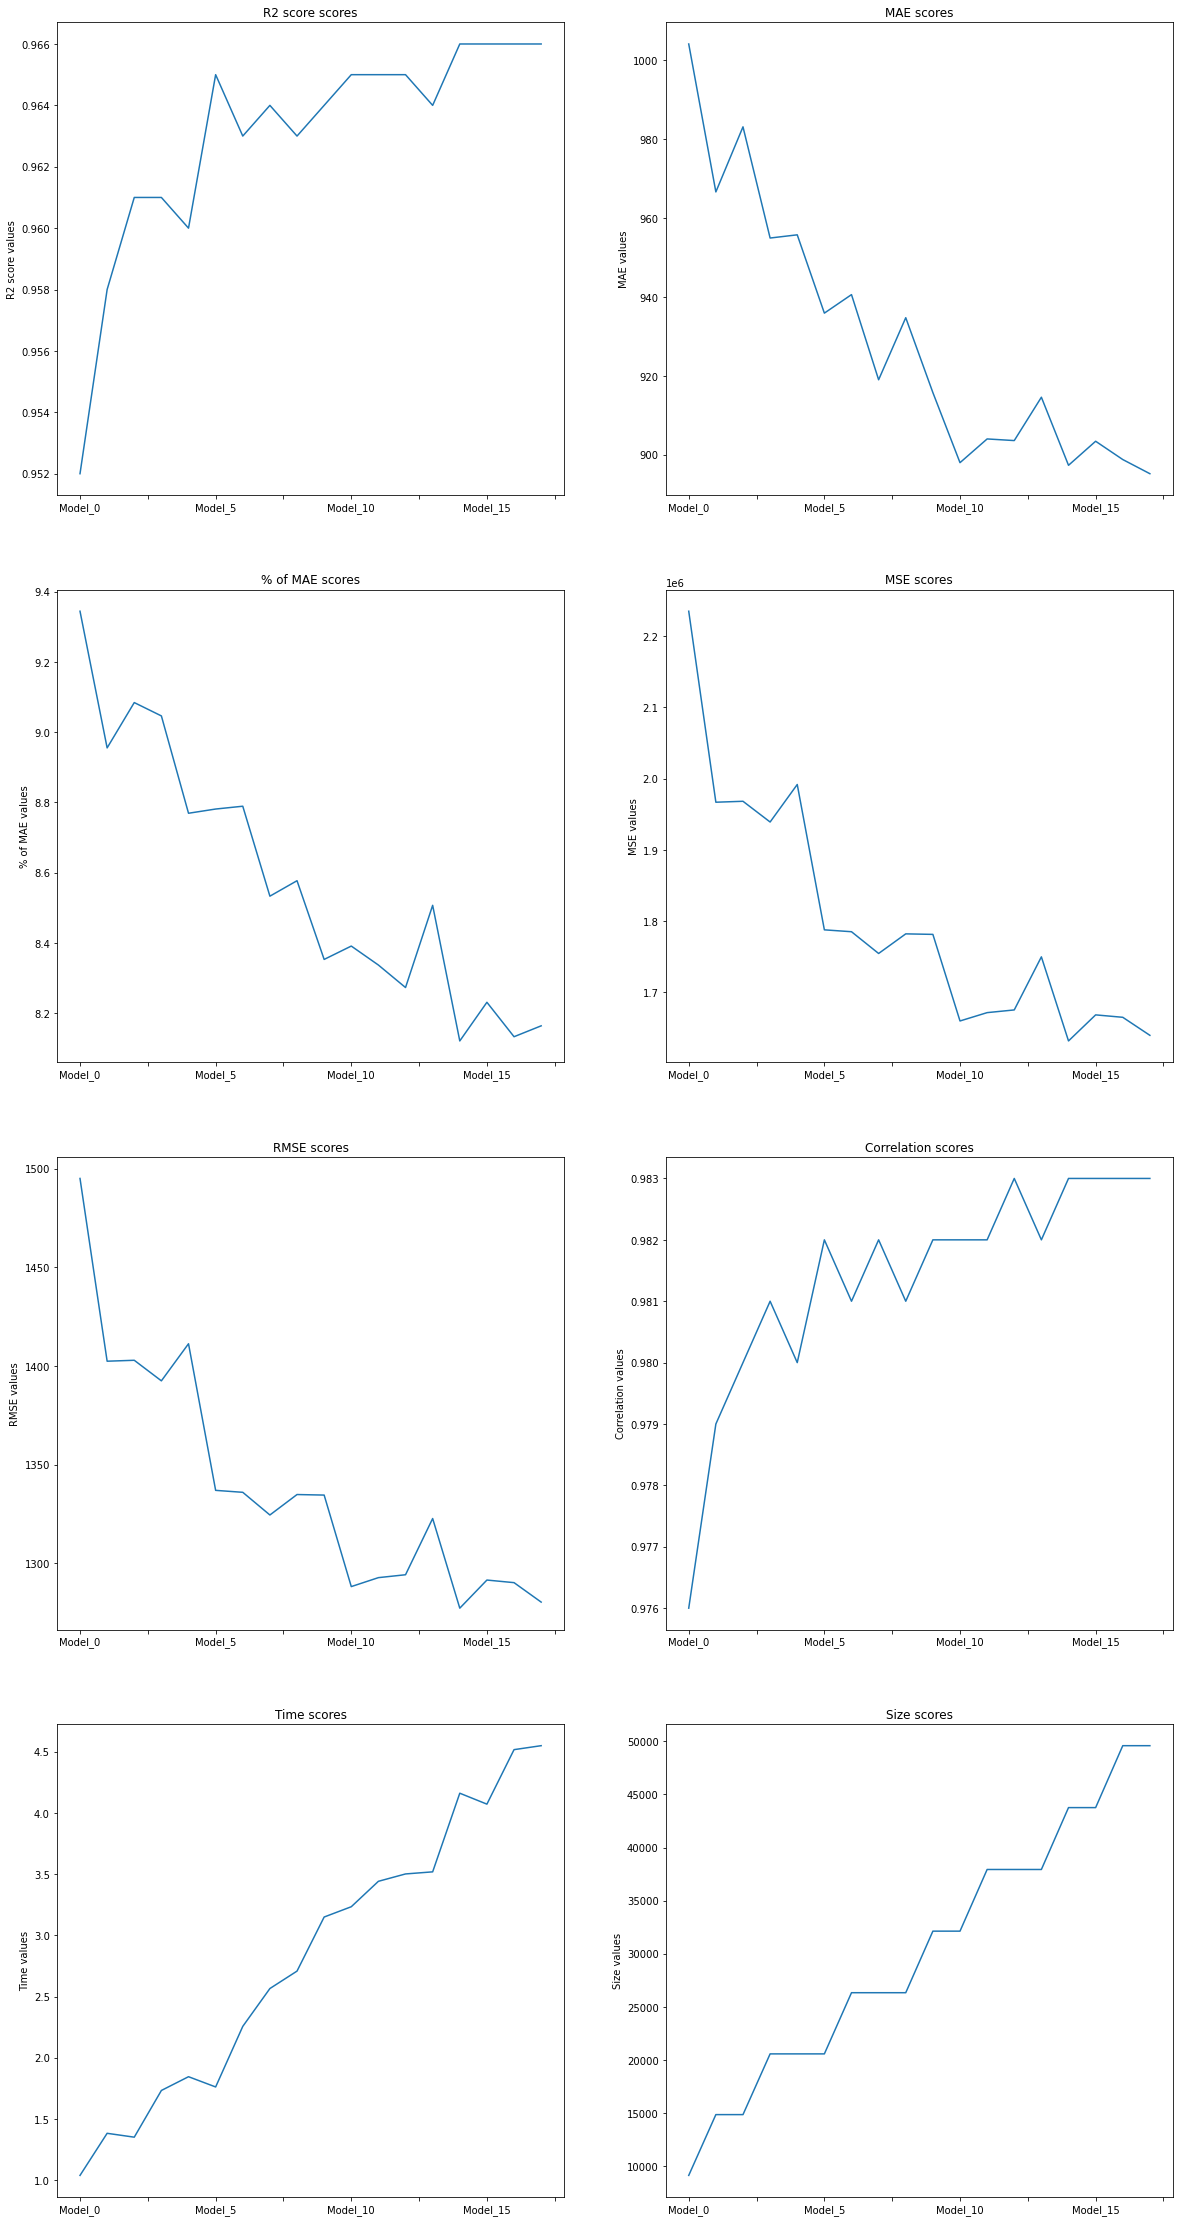

In [48]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp3.index):
    plt.subplot(4,2,i+1)
    df_scores_exp3.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [49]:
len(data)

49596

In [50]:
process_dict

{0: 'Concatenation',
 1: 'Concatenation',
 2: 'Sliding Window',
 3: 'Concatenation',
 4: 'Sliding Window',
 5: 'Sliding Window',
 6: 'Concatenation',
 7: 'Sliding Window',
 8: 'Sliding Window',
 9: 'Concatenation',
 10: 'Sliding Window',
 11: 'Concatenation',
 12: 'Sliding Window',
 13: 'Sliding Window',
 14: 'Concatenation',
 15: 'Sliding Window',
 16: 'Concatenation',
 17: 'Sliding Window'}

In [51]:
df_scores_exp3.to_excel('exp3_scores.xlsx')

### Experiment 4

30 chunks

In [52]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

idx_grp = data_stratification(df_, 'Group', 30)

In [53]:
data = pd.DataFrame()

process_dict = {}

for grp in idx_grp.keys():
   
    if grp > 1:

        
        if globals()[f'per_mae_{grp-1}'] - globals()[f'per_mae_{grp-2}'] > 0.01:
            
            concat_data(grp)
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp)
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else:
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']

In [54]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp4 = pd.concat([exp_res, a])

df_scores_exp4.rename(columns=cols, inplace=True)

In [55]:
df_scores_exp4

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,...,Model_20,Model_21,Model_22,Model_23,Model_24,Model_25,Model_26,Model_27,Model_28,Model_29
R2 score,9.510000e-01,9.550000e-01,9.580000e-01,9.620000e-01,9.540000e-01,9.620000e-01,9.600000e-01,9.590000e-01,9.600000e-01,9.610000e-01,...,9.640000e-01,9.640000e-01,9.660000e-01,9.650000e-01,9.670000e-01,9.660000e-01,9.660000e-01,9.660000e-01,9.670000e-01,9.650000e-01
MAE,1.072309e+03,9.923260e+02,1.008951e+03,9.812420e+02,1.004729e+03,9.655820e+02,9.690490e+02,9.844320e+02,9.662840e+02,9.579620e+02,...,9.162180e+02,9.154390e+02,9.125310e+02,9.041620e+02,8.888670e+02,8.898060e+02,8.786930e+02,8.944930e+02,8.860970e+02,8.982660e+02
% of MAE,9.992000e+00,9.172000e+00,9.784000e+00,9.399000e+00,9.256000e+00,9.005000e+00,8.605000e+00,9.138000e+00,8.898000e+00,8.620000e+00,...,8.227000e+00,8.284000e+00,8.406000e+00,8.136000e+00,8.127000e+00,8.130000e+00,8.138000e+00,8.099000e+00,8.067000e+00,8.141000e+00
MSE,2.334652e+06,2.072422e+06,2.159703e+06,1.961709e+06,2.382382e+06,1.864418e+06,1.964502e+06,1.993507e+06,1.958068e+06,1.868429e+06,...,1.735463e+06,1.730465e+06,1.656496e+06,1.674234e+06,1.587617e+06,1.593582e+06,1.554200e+06,1.648394e+06,1.573991e+06,1.677149e+06
RMSE,1.527957e+03,1.439591e+03,1.469593e+03,1.400610e+03,1.543497e+03,1.365437e+03,1.401607e+03,1.411916e+03,1.399310e+03,1.366905e+03,...,1.317370e+03,1.315472e+03,1.287049e+03,1.293922e+03,1.260007e+03,1.262372e+03,1.246675e+03,1.283898e+03,1.254588e+03,1.295048e+03
Correlation,9.750000e-01,9.770000e-01,9.790000e-01,9.810000e-01,9.760000e-01,9.810000e-01,9.800000e-01,9.790000e-01,9.800000e-01,9.800000e-01,...,9.820000e-01,9.820000e-01,9.830000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.820000e-01
Time,8.844409e-01,1.414325e+00,2.050649e+00,1.938751e+00,2.240951e+00,1.866318e+00,2.055228e+00,2.218090e+00,2.955456e+00,3.105729e+00,...,3.595619e+00,3.531733e+00,3.679043e+00,3.895735e+00,4.002106e+00,4.269871e+00,4.055835e+00,3.472453e+00,3.389230e+00,3.263759e+00
Size,5.611000e+03,9.073000e+03,9.073000e+03,1.253100e+04,1.253100e+04,1.253100e+04,1.253100e+04,1.253100e+04,1.601000e+04,1.601000e+04,...,3.008000e+04,3.008000e+04,3.361000e+04,3.716100e+04,3.716100e+04,3.716100e+04,3.716100e+04,3.716100e+04,3.716100e+04,3.716100e+04


<function matplotlib.pyplot.show(close=None, block=None)>

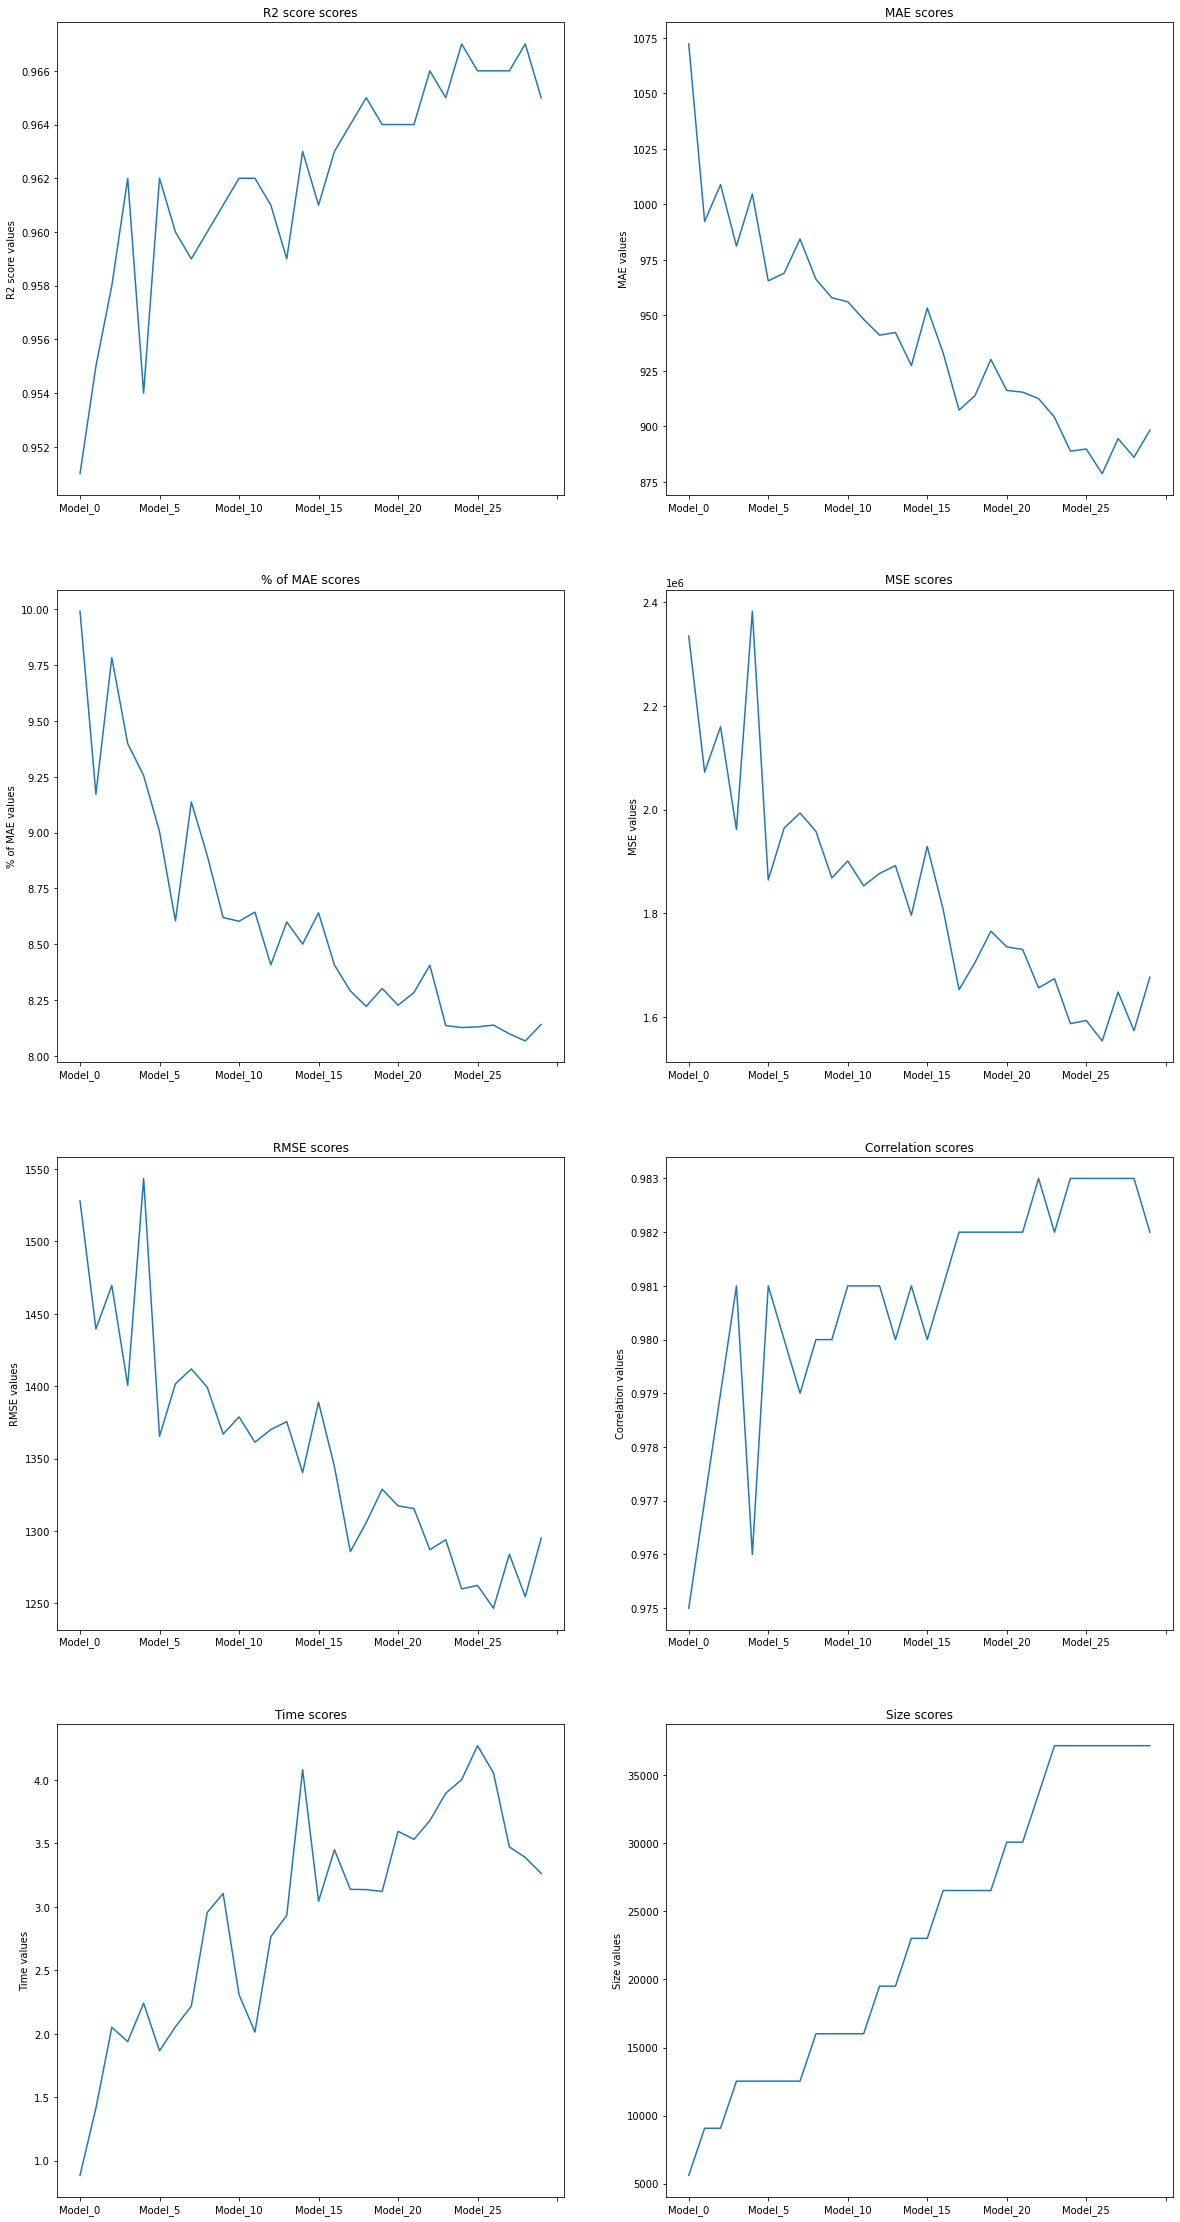

In [56]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp4.index):
    plt.subplot(4,2,i+1)
    df_scores_exp4.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [57]:
df_scores_exp4.to_excel('exp4_scores.xlsx')

### Experiment 5

40 chunks

In [58]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

idx_grp = data_stratification(df_, 'Group', 40)

In [59]:
data = pd.DataFrame()

process_dict = {}

for grp in idx_grp.keys():
   
    if grp > 1:

        
        if globals()[f'per_mae_{grp-1}'] - globals()[f'per_mae_{grp-2}'] > 0.01:
            
            concat_data(grp)
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp)
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else:
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']

In [60]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp5 = pd.concat([exp_res, a])

df_scores_exp5.rename(columns=cols, inplace=True)

In [61]:
df_scores_exp5

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,...,Model_30,Model_31,Model_32,Model_33,Model_34,Model_35,Model_36,Model_37,Model_38,Model_39
R2 score,9.480000e-01,9.560000e-01,9.530000e-01,9.540000e-01,9.600000e-01,9.590000e-01,9.590000e-01,9.600000e-01,9.530000e-01,9.620000e-01,...,9.650000e-01,9.650000e-01,9.650000e-01,9.650000e-01,9.640000e-01,9.660000e-01,9.650000e-01,9.640000e-01,9.650000e-01,9.670000e-01
MAE,1.059960e+03,1.013422e+03,1.070170e+03,1.006236e+03,9.764900e+02,9.930480e+02,9.881510e+02,9.750010e+02,9.788090e+02,9.535180e+02,...,9.135590e+02,9.101930e+02,9.082830e+02,8.907940e+02,9.115760e+02,8.910070e+02,8.927040e+02,9.034150e+02,8.910600e+02,8.756830e+02
% of MAE,1.005700e+01,9.142000e+00,1.000500e+01,9.656000e+00,9.491000e+00,9.602000e+00,9.917000e+00,9.241000e+00,8.672000e+00,8.833000e+00,...,8.247000e+00,8.259000e+00,8.216000e+00,7.995000e+00,8.210000e+00,8.161000e+00,7.993000e+00,8.178000e+00,7.963000e+00,7.910000e+00
MSE,2.148837e+06,2.097521e+06,2.433883e+06,2.368024e+06,1.982373e+06,2.042575e+06,2.097085e+06,2.054358e+06,2.255026e+06,1.811834e+06,...,1.694794e+06,1.714680e+06,1.683448e+06,1.640534e+06,1.723189e+06,1.627501e+06,1.673685e+06,1.730733e+06,1.650310e+06,1.570257e+06
RMSE,1.465891e+03,1.448282e+03,1.560091e+03,1.538839e+03,1.407968e+03,1.429187e+03,1.448131e+03,1.433303e+03,1.501674e+03,1.346044e+03,...,1.301843e+03,1.309458e+03,1.297478e+03,1.280833e+03,1.312703e+03,1.275735e+03,1.293710e+03,1.315573e+03,1.284644e+03,1.253099e+03
Correlation,9.730000e-01,9.780000e-01,9.760000e-01,9.770000e-01,9.800000e-01,9.790000e-01,9.790000e-01,9.800000e-01,9.760000e-01,9.810000e-01,...,9.820000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.820000e-01,9.830000e-01,9.820000e-01,9.820000e-01,9.820000e-01,9.830000e-01
Time,4.784722e-01,7.998455e-01,8.356304e-01,1.000578e+00,1.014858e+00,1.007924e+00,1.212803e+00,1.377500e+00,1.592064e+00,1.531283e+00,...,3.461646e+00,3.168874e+00,3.766211e+00,6.206753e+00,3.973742e+00,4.706722e+00,4.595057e+00,4.387459e+00,4.754521e+00,4.659916e+00
Size,4.282000e+03,6.885000e+03,6.885000e+03,9.476000e+03,9.476000e+03,9.476000e+03,1.207100e+04,1.465700e+04,1.465700e+04,1.465700e+04,...,3.309600e+04,3.577400e+04,3.846400e+04,3.846400e+04,3.846400e+04,4.119000e+04,4.119000e+04,4.119000e+04,4.395100e+04,4.395100e+04


<function matplotlib.pyplot.show(close=None, block=None)>

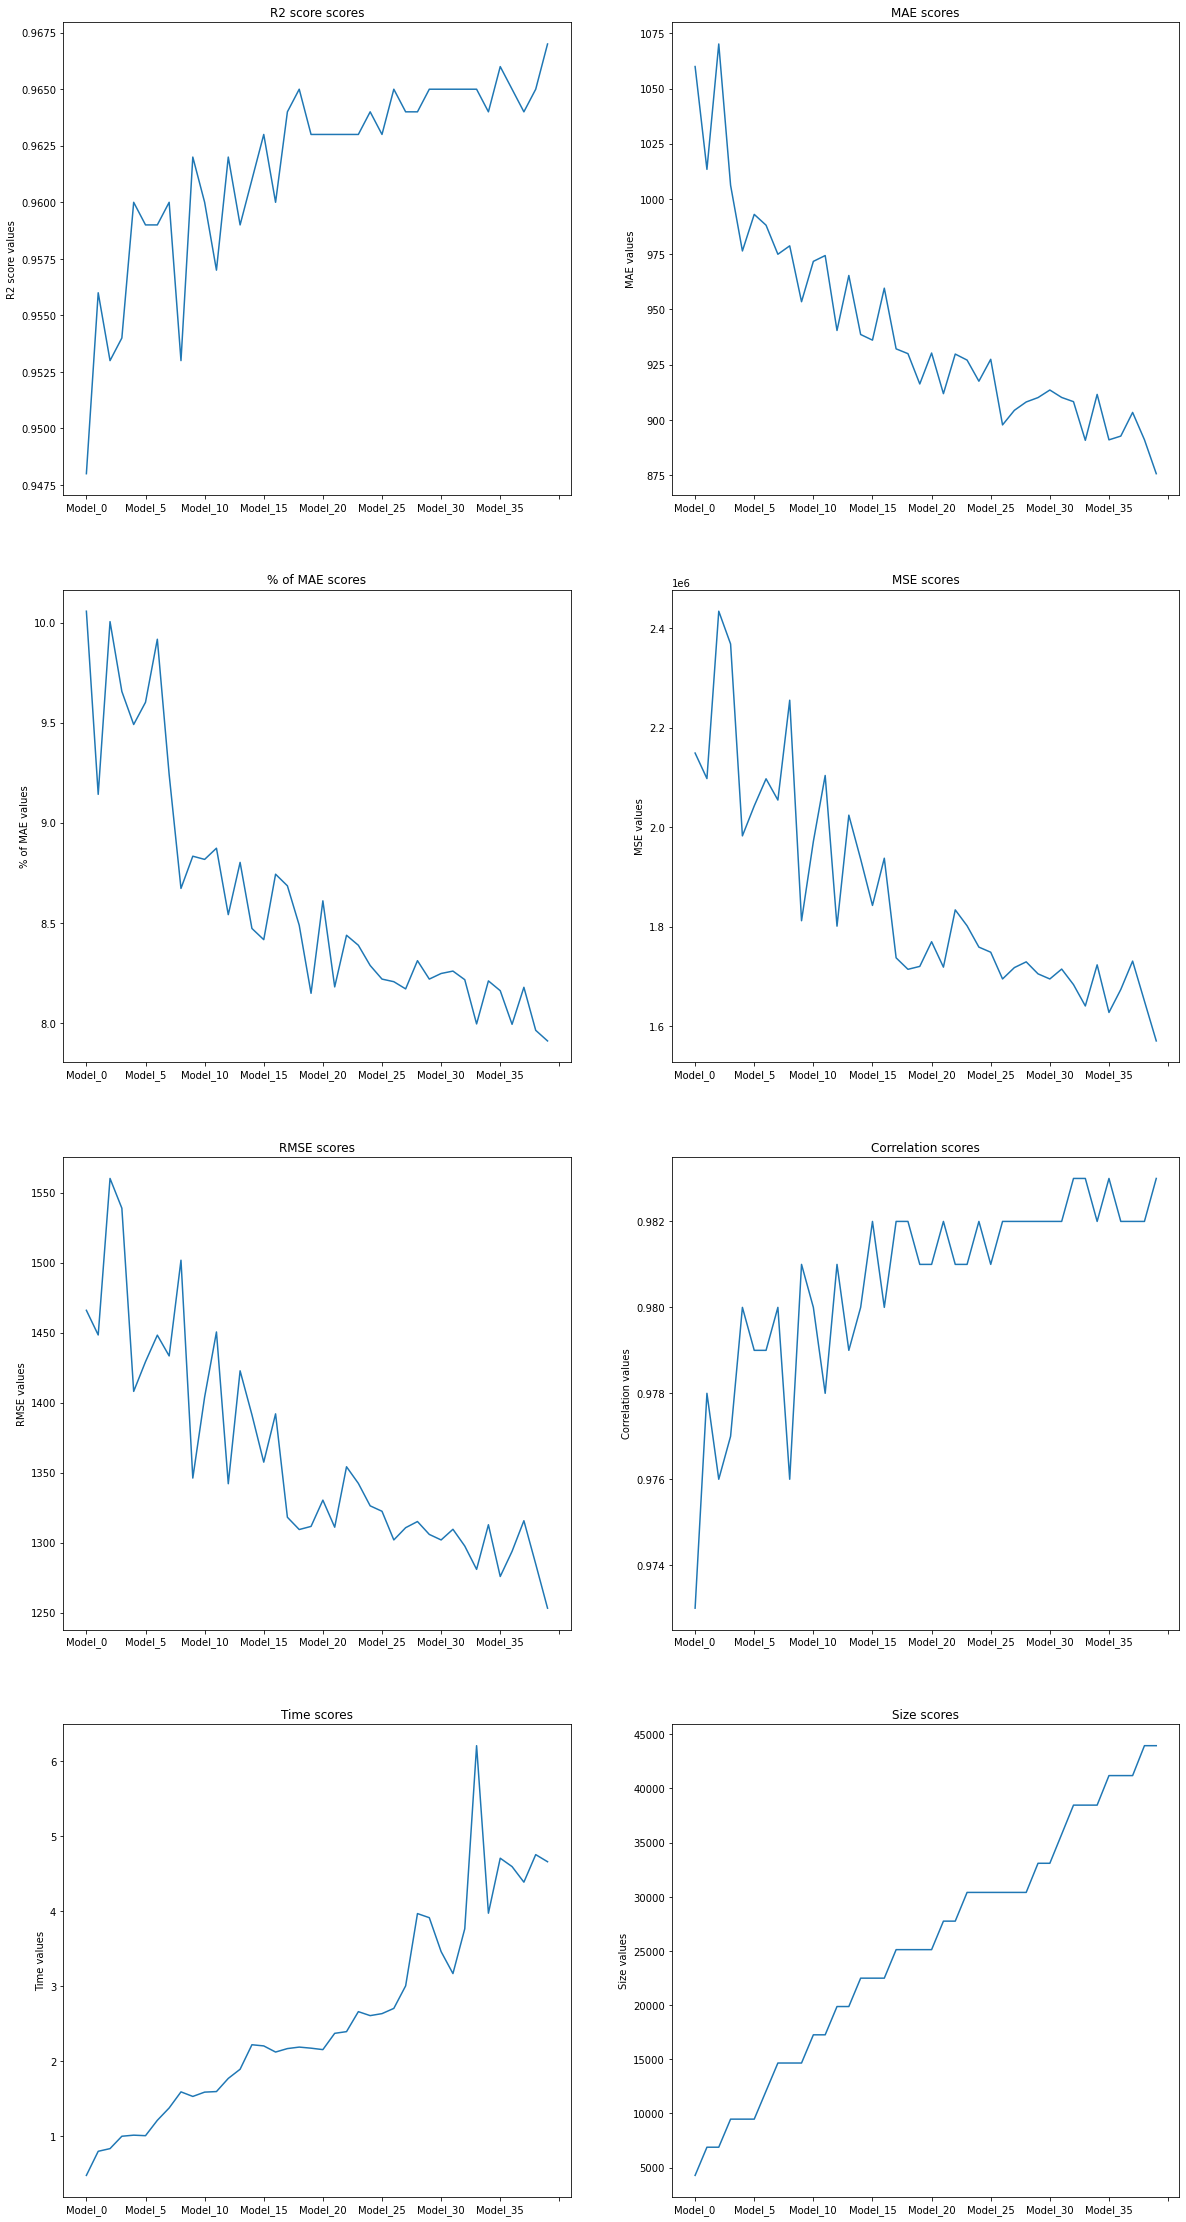

In [62]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp5.index):
    plt.subplot(4,2,i+1)
    df_scores_exp5.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [63]:
df_scores_exp5.to_excel('exp5_scores.xlsx')

### Experiment 6

50 chunks

In [64]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

idx_grp = data_stratification(df_, 'Group', 50)

In [65]:
data = pd.DataFrame()

process_dict = {}

for grp in idx_grp.keys():
   
    if grp > 1:

        
        if globals()[f'per_mae_{grp-1}'] - globals()[f'per_mae_{grp-2}'] > 0.01:
            
            concat_data(grp)
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp)
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else:
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']

In [66]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp6 = pd.concat([exp_res, a])

df_scores_exp6.rename(columns=cols, inplace=True)

In [67]:
df_scores_exp6

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,...,Model_40,Model_41,Model_42,Model_43,Model_44,Model_45,Model_46,Model_47,Model_48,Model_49
R2 score,9.490000e-01,9.550000e-01,9.340000e-01,9.520000e-01,9.560000e-01,9.560000e-01,9.570000e-01,9.580000e-01,9.610000e-01,9.580000e-01,...,9.660000e-01,9.660000e-01,9.660000e-01,9.650000e-01,9.670000e-01,9.670000e-01,9.650000e-01,9.650000e-01,9.670000e-01,9.660000e-01
MAE,1.093865e+03,9.998160e+02,1.111275e+03,1.069479e+03,1.025474e+03,1.026918e+03,9.908910e+02,1.001298e+03,9.645540e+02,9.637730e+02,...,8.821510e+02,8.924840e+02,8.907730e+02,8.942260e+02,8.837450e+02,8.777720e+02,9.106450e+02,8.883760e+02,8.743930e+02,8.903880e+02
% of MAE,1.036700e+01,9.375000e+00,9.801000e+00,1.010800e+01,9.486000e+00,9.827000e+00,9.233000e+00,9.438000e+00,9.319000e+00,8.845000e+00,...,8.044000e+00,8.051000e+00,8.241000e+00,8.223000e+00,8.086000e+00,7.997000e+00,8.235000e+00,8.066000e+00,8.084000e+00,8.089000e+00
MSE,2.301867e+06,2.097794e+06,3.295740e+06,2.446287e+06,2.273996e+06,2.206246e+06,2.160325e+06,2.036138e+06,1.883030e+06,2.060229e+06,...,1.617343e+06,1.625240e+06,1.595169e+06,1.651981e+06,1.555747e+06,1.539461e+06,1.685311e+06,1.660434e+06,1.564425e+06,1.632459e+06
RMSE,1.517190e+03,1.448376e+03,1.815417e+03,1.564061e+03,1.507977e+03,1.485344e+03,1.469805e+03,1.426933e+03,1.372235e+03,1.435350e+03,...,1.271748e+03,1.274849e+03,1.263000e+03,1.285294e+03,1.247296e+03,1.240750e+03,1.298195e+03,1.288578e+03,1.250770e+03,1.277677e+03
Correlation,9.740000e-01,9.770000e-01,9.670000e-01,9.760000e-01,9.780000e-01,9.780000e-01,9.780000e-01,9.790000e-01,9.800000e-01,9.790000e-01,...,9.830000e-01,9.830000e-01,9.830000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.820000e-01,9.820000e-01,9.830000e-01,9.830000e-01
Time,6.138887e-01,9.235871e-01,8.803430e-01,1.423827e+00,1.613833e+00,1.479527e+00,1.549129e+00,1.602484e+00,2.119521e+00,2.137157e+00,...,4.625883e+00,4.198447e+00,4.974170e+00,7.849922e+00,5.559705e+00,6.045987e+00,5.284079e+00,7.116012e+00,5.723079e+00,7.937957e+00
Size,3.495000e+03,5.568000e+03,5.568000e+03,7.635000e+03,9.705000e+03,9.705000e+03,1.178300e+04,1.178300e+04,1.385900e+04,1.385900e+04,...,4.143100e+04,4.143100e+04,4.143100e+04,4.360000e+04,4.360000e+04,4.360000e+04,4.360000e+04,4.581000e+04,4.581000e+04,4.806100e+04


<function matplotlib.pyplot.show(close=None, block=None)>

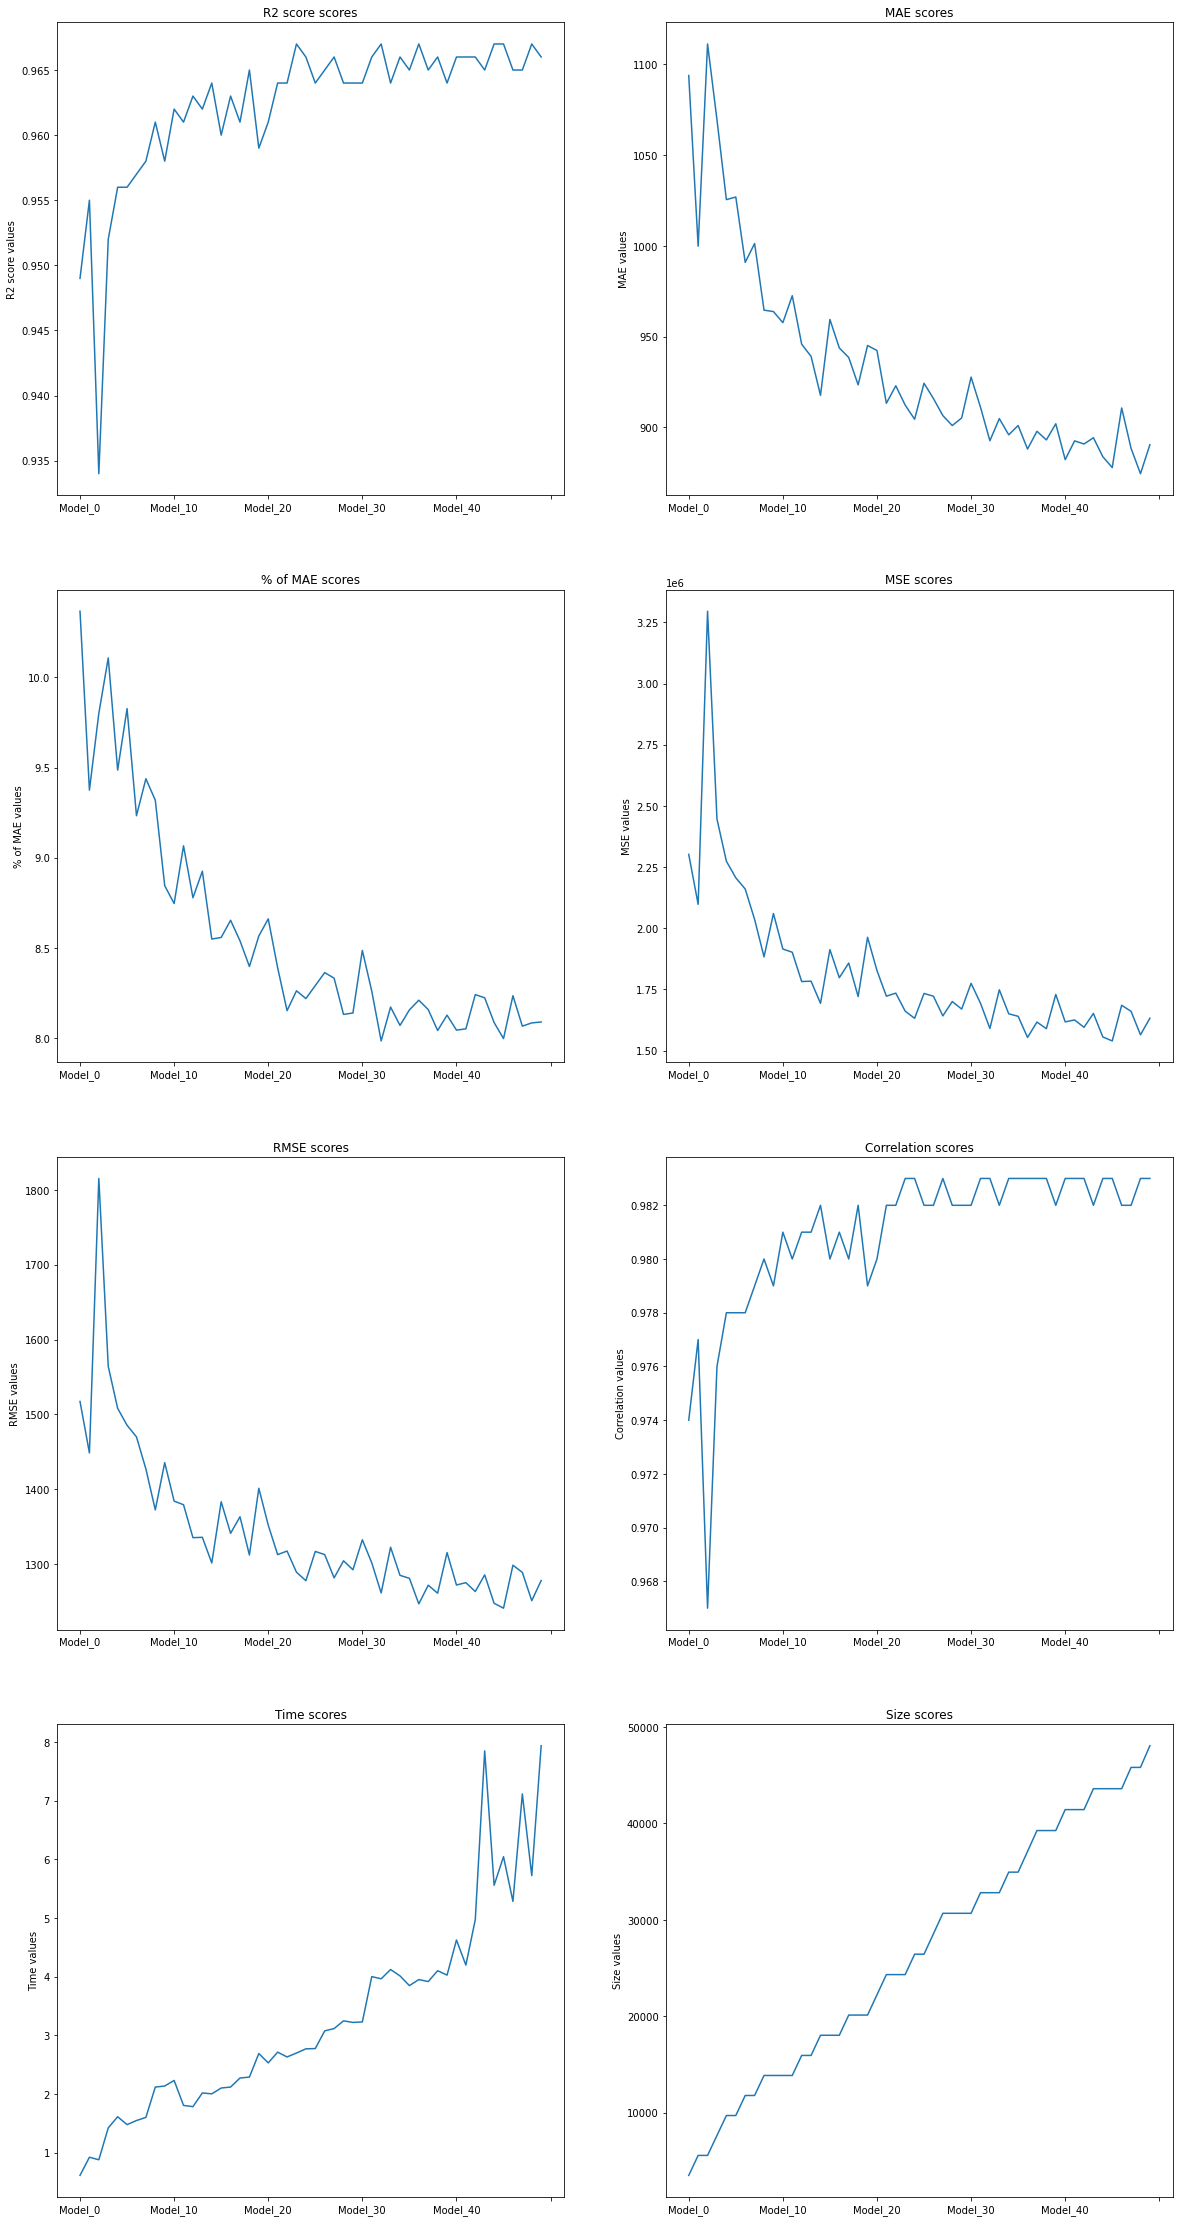

In [68]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp6.index):
    plt.subplot(4,2,i+1)
    df_scores_exp6.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [69]:
len(data)

48061

In [70]:
df_scores_exp6.to_excel('exp6_scores.xlsx')

### Experiment 7

100 chunks

In [71]:
df_ = df[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

idx_grp = data_stratification(df_, 'Group', 100)

In [72]:
data = pd.DataFrame()

process_dict = {}

for grp in idx_grp.keys():
   
    if grp > 1:

        
        if globals()[f'per_mae_{grp-1}'] - globals()[f'per_mae_{grp-2}'] > 0.01:
            
            concat_data(grp)
            process_dict[grp] = 'Concatenation'
        
        else:
            
            slide(grp)
            process_dict[grp] = 'Sliding Window'
            
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']
        
    else:
           
        concat_data(grp)
        process_dict[grp] = 'Concatenation'
        
        X_train, X_test, y_train, y_test = split_data()
        start = time.time()
        model = modelling()
        end = time.time()
        y_pred = pred_values(model)
        globals()[f'score_model_{grp}'] = eval_metrics(y_test, y_pred)
        globals()[f'time_{grp}'] = end - start
        globals()[f'size_{grp}'] = len(data)
        globals()[f'per_mae_{grp}'] = eval_metrics(y_test, y_pred)['% of MAE']

In [73]:
scores = [f'score_model_{i}' for i in idx_grp.keys()]

time_ = [f'time_{i}' for i in idx_grp.keys()]

size_ = [f'size_{i}' for i in idx_grp.keys()]

cols = {i:f'Model_{i}' for i in idx_grp.keys()}

exp_res = pd.concat([globals()[i] for i in scores], axis=1)
a = pd.DataFrame([[globals()[i] for i in time_], [globals()[i] for i in size_]], index=['Time', 'Size'])

df_scores_exp7 = pd.concat([exp_res, a])

df_scores_exp7.rename(columns=cols, inplace=True)

In [74]:
df_scores_exp7

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,...,Model_90,Model_91,Model_92,Model_93,Model_94,Model_95,Model_96,Model_97,Model_98,Model_99
R2 score,9.390000e-01,9.460000e-01,9.400000e-01,9.450000e-01,9.450000e-01,9.490000e-01,9.560000e-01,9.560000e-01,9.510000e-01,9.530000e-01,...,9.660000e-01,9.660000e-01,9.660000e-01,9.660000e-01,9.650000e-01,9.660000e-01,9.660000e-01,9.670000e-01,9.670000e-01,9.650000e-01
MAE,1.228131e+03,1.174194e+03,1.090952e+03,1.023766e+03,1.117542e+03,1.088676e+03,9.999010e+02,1.024002e+03,1.061626e+03,1.032765e+03,...,8.817610e+02,8.810590e+02,8.788110e+02,8.910410e+02,8.857250e+02,8.819800e+02,8.792880e+02,8.835830e+02,8.864610e+02,8.762400e+02
% of MAE,1.077800e+01,1.112300e+01,1.145900e+01,9.895000e+00,1.321800e+01,1.319800e+01,1.110300e+01,1.004100e+01,1.007000e+01,1.005500e+01,...,7.729000e+00,7.771000e+00,7.748000e+00,7.802000e+00,7.726000e+00,7.760000e+00,7.669000e+00,7.712000e+00,7.747000e+00,7.658000e+00
MSE,3.076552e+06,2.870706e+06,3.101853e+06,2.901324e+06,2.961875e+06,2.679090e+06,2.220610e+06,2.260990e+06,2.452416e+06,2.335297e+06,...,1.576881e+06,1.568913e+06,1.558339e+06,1.629930e+06,1.665584e+06,1.543003e+06,1.604629e+06,1.570630e+06,1.604002e+06,1.597342e+06
RMSE,1.754010e+03,1.694316e+03,1.761208e+03,1.703327e+03,1.721010e+03,1.636793e+03,1.490171e+03,1.503659e+03,1.566019e+03,1.528168e+03,...,1.255739e+03,1.252563e+03,1.248334e+03,1.276687e+03,1.290575e+03,1.242177e+03,1.266740e+03,1.253248e+03,1.266492e+03,1.263860e+03
Correlation,9.700000e-01,9.730000e-01,9.700000e-01,9.720000e-01,9.720000e-01,9.740000e-01,9.780000e-01,9.780000e-01,9.750000e-01,9.760000e-01,...,9.830000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.820000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.830000e-01,9.830000e-01
Time,3.839707e-01,6.820881e-01,1.126951e+00,1.108457e+00,1.035409e+00,1.201329e+00,1.445272e+00,1.203077e+00,9.641752e-01,1.003366e+00,...,4.750053e+00,9.174436e+00,9.078711e+00,5.114950e+00,6.083277e+00,5.669737e+00,4.914866e+00,4.236854e+00,4.435643e+00,4.503334e+00
Size,1.776000e+03,2.854000e+03,3.927000e+03,4.995000e+03,4.995000e+03,6.055000e+03,6.055000e+03,6.055000e+03,6.055000e+03,7.114000e+03,...,4.013900e+04,4.013900e+04,4.124200e+04,4.124200e+04,4.233300e+04,4.233300e+04,4.343700e+04,4.343700e+04,4.457300e+04,4.575900e+04


<function matplotlib.pyplot.show(close=None, block=None)>

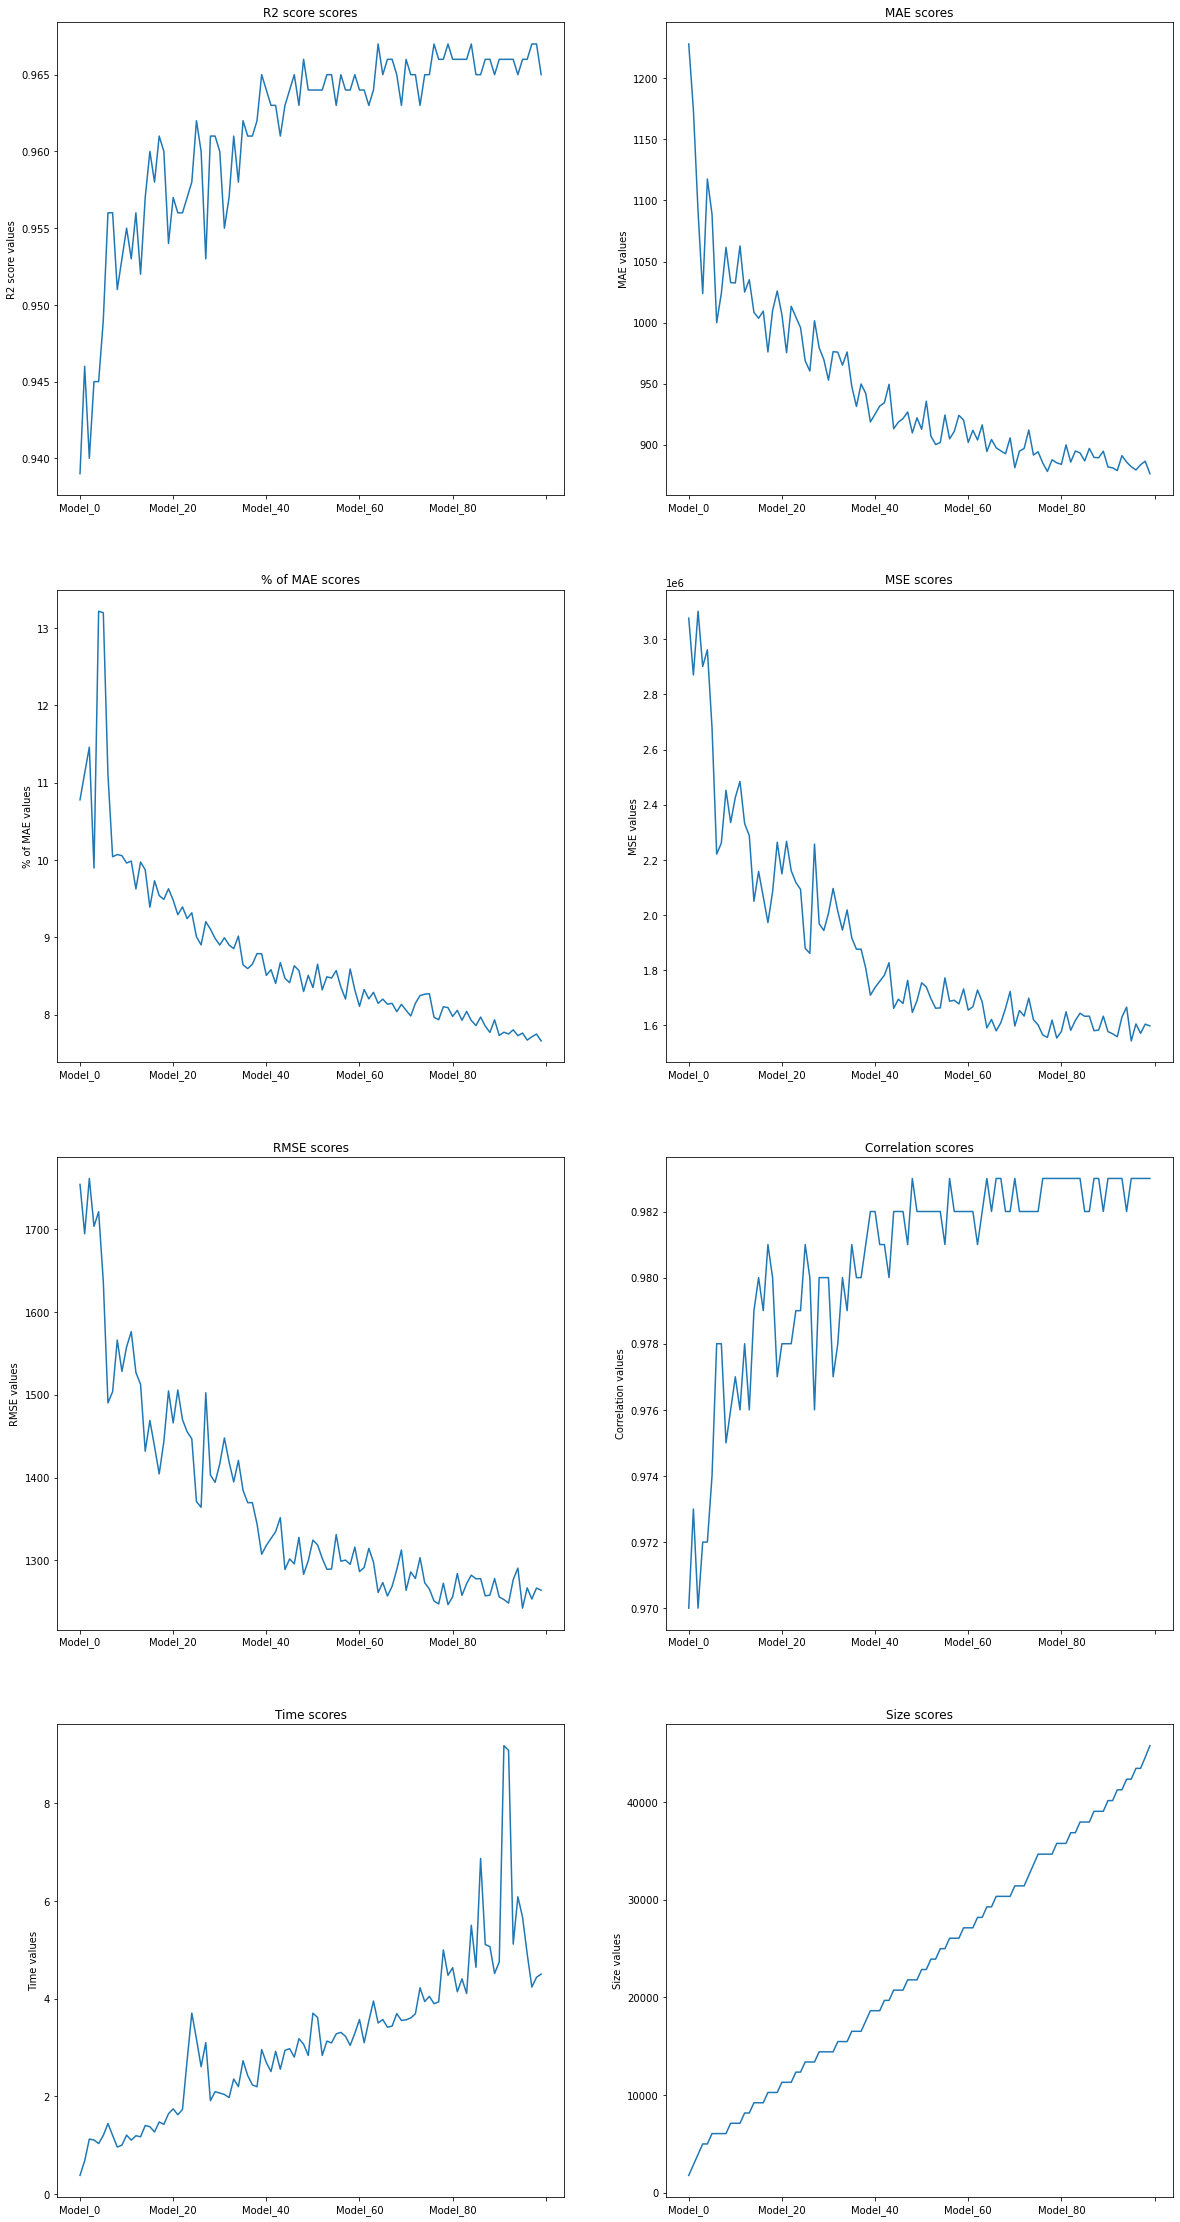

In [75]:
plt.figure(figsize=(20,40))

for i, k in enumerate(df_scores_exp7.index):
    plt.subplot(4,2,i+1)
    df_scores_exp7.loc[k].plot()
    plt.title(f'{k} scores')
    plt.ylabel(f'{k} values')


plt.show

In [76]:
df_scores_exp7.to_excel('exp7_scores.xlsx')